In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score,accuracy_score, confusion_matrix, roc_curve

In [2]:
df = pd.read_pickle('cleaned_df.pkl')
seed = 123

In [3]:
df.head()

,clothing_ID,Age,Title,Text,review_len,Positive_fb_count,Division,Department,Class,Positively_rated,Reco
original_ind,,,,,,,,,,,
0,767,33,absolutely wonderful,absolutely wonderful silky and sexy and comf...,53,0,Initmates,Intimate,Intimates,1,1
1,1080,34,love this dress,love this dress it s sooo pretty i happene...,303,4,General,Dresses,Dresses,1,1
2,1077,60,some major design flaws,i had such high hopes for this dress and reall...,500,0,General,Dresses,Dresses,0,0
3,1049,50,my favorite buy,i love love love this jumpsuit it s fun fl...,124,0,General Petite,Bottoms,Pants,1,1
4,847,47,flattering shirt,this shirt is very flattering to all due to th...,192,6,General,Tops,Blouses,1,1


In [4]:
#define our own train test split, as I wish to keep the train/test as seperate data frames for easy reference
def train_test_split_df (df,test_size = 0.2):
    idx = list(df.index)
    random.Random(seed).shuffle(idx)
    test_len = int(test_size * len(df))
    return df.loc[idx[test_len:]],df.loc[idx[:test_len]]

In [5]:
data_train,data_test = train_test_split_df(df)

In [6]:
data_train.to_pickle('train_set.pkl')
data_test.to_pickle('test_set.pkl')

In [7]:
columns_to_keep = ['clothing_ID','Age','review_len','Positive_fb_count','Division','Department','Class']
categorical_features = ['Division','Department','Class']
data_train_features_only_wo_text = data_train[columns_to_keep]

In [8]:
data_train_features_only_dummied = pd.get_dummies(data_train_features_only_wo_text,categorical_features)

In [9]:
data_test_features_only_wo_text = data_train[columns_to_keep]
data_test_features_only_dummied = pd.get_dummies(data_test_features_only_wo_text,categorical_features)

We will start with our first bag of words model without any lemmatization and stopwords removal

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(data_train.Text, 
                                                    data_train.Positively_rated, test_size=0.25,
                                                    random_state=0)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data (Bag of Words model)
vect = CountVectorizer().fit(X_train)

In [12]:
vect.get_feature_names()[::1000]

['00',
 'ate',
 'charlie',
 'designed',
 'filigree',
 'host',
 'loungers',
 'ot',
 'raves',
 'shrunk',
 'tangerine',
 'war']

In [13]:
len(vect.get_feature_names())

11458

In [14]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train).toarray()
X_train_add = data_train_features_only_dummied.loc[list(X_train.index)].to_numpy()
X_train_vect_stack = np.hstack((X_train_vectorized,X_train_add))

In [15]:
def model_fit_train_score (model,x_train,y_train,x_val,y_val):
    '''This function takes in five arguments:model (model object), X_train, y_train, X_test_val,y_val
    The data will be fitted using the model passed in by the user
    It returns the fitted model object and Accuracy score as well as F1 score and AUC (area under curve)'''
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    predictions = model.predict_proba(x_val)
    
    keys = ['predictions','predict_proba','Accuracy','F1','AUC']
    
    results_dict = dict.fromkeys(keys)
    results_dict['predictions'] = y_pred
    results_dict['predict_proba'] = predictions[:,1]
    results_dict['Accuracy'] = accuracy_score(y_true=y_val, y_pred=y_pred)
    results_dict['F1'] = f1_score(y_true=y_val, y_pred=y_pred)
    results_dict['AUC'] = roc_auc_score(y_val, predictions[:,1])
    
    return model,results_dict

In [16]:
#X_val need to be treated the same as X_train
X_val_vectorized = vect.transform(X_val).toarray()
X_val_add = data_train_features_only_dummied.loc[list(X_val.index)].to_numpy()
X_val_vect_stack = np.hstack((X_val_vectorized,X_val_add))

In [17]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression()

fitted_model,results = model_fit_train_score(model,X_train_vect_stack, y_train,X_val_vect_stack,y_val)

/Users/zhengzhiqing/opt/anaconda3/envs/metisnow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.846 
F1 score: 0.904 
AUC score: 0.879


In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap = 'Greens')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

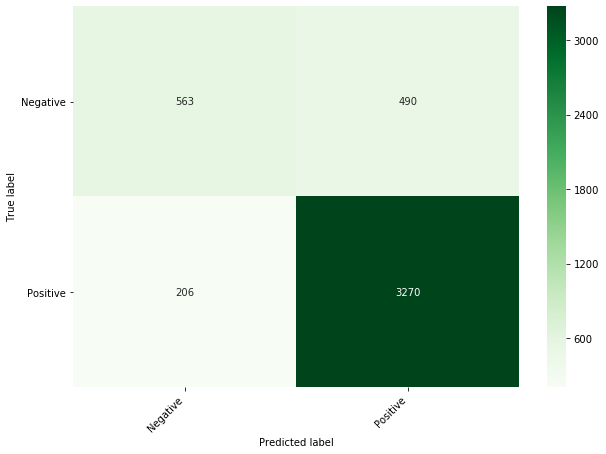

In [20]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

For this project we will maximize accuracy because we want to identify negative and positive comments respectively


In [21]:
def plot_ROC(y_true,y_proba,AUC,figsize = (7,5),color = 'darkturquoise',title='ROC Curve'):
    '''Helper function to plot ROC graph'''
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    #set size
    plt.figure(figsize=figsize)
    #plot
    plt.plot(fpr, tpr,lw=2,c=color,label = f"AUC: {AUC:.2f}")
    #adjustments
    plt.plot([0,1],[0,1],c='grey',ls='--')
    plt.legend()
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title);

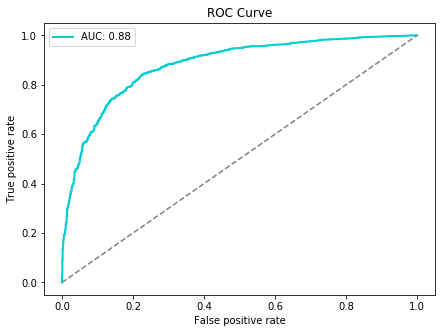

In [22]:
plot_ROC(y_val,results['predict_proba'],results['AUC'])
plt.savefig("ROC_curve_1st_model_w_all_features.png")

Now let's try to fit the model using just the text component and throw away all the other features

In [23]:
model = LogisticRegression()

In [24]:
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y_train,X_val_vectorized,y_val)

/Users/zhengzhiqing/opt/anaconda3/envs/metisnow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.869 
F1 score: 0.916 
AUC score: 0.912


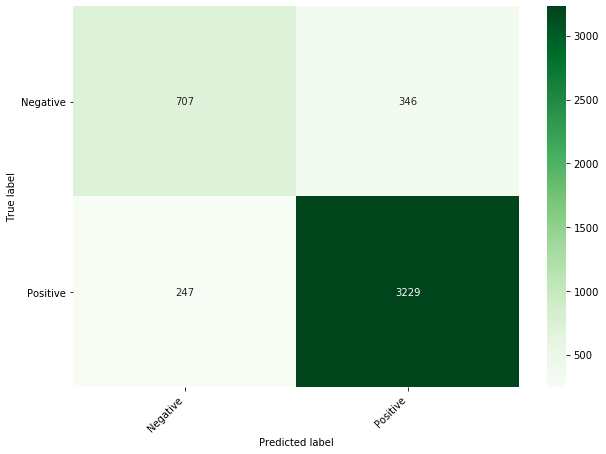

In [26]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

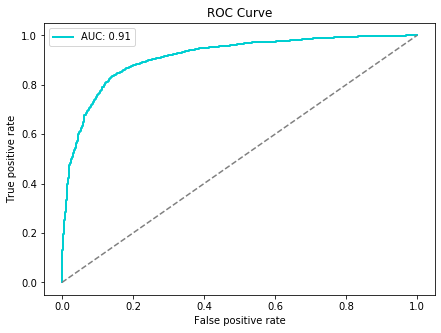

In [27]:
plot_ROC(y_val,results['predict_proba'],results['AUC'])

In [32]:
type(vect.get_feature_names())

list

In [33]:
#try to see the 
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['poor' 'within' 'awful' 'unflattering' 'drab' 'start' 'cheap' 'bad'
 'disappointed' 'completely']

Largest Coefs: 
['highly' 'compliments' 'pleased' 'sexy' 'breast' 'hesitant' 'helps'
 'gigantic' 'paired' 'stylish']


It is quite a surprising finding, it shows that when we only fit the logistic regression model with the review textx only, the model performance improves by reading AUC score..

Let's see if we need to keep the other features other than review by looking at the feature importance/ ranking from logistic model and random forest

In [81]:
model = LogisticRegression()
fitted_model,results = model_fit_train_score(model,X_train_add, y_train,X_val_add,y_val)

In [82]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.767 
F1 score: 0.868 
AUC score: 0.561


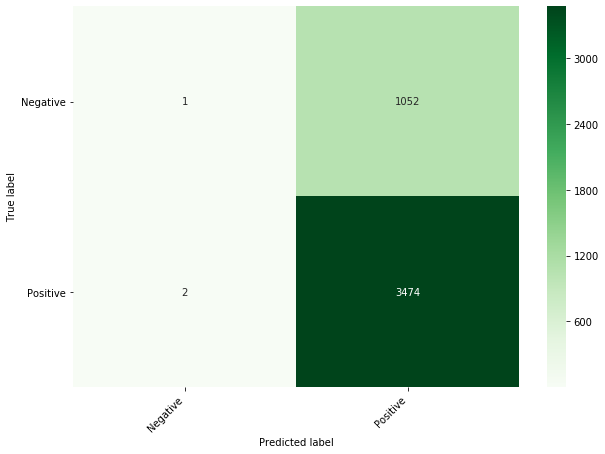

In [83]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

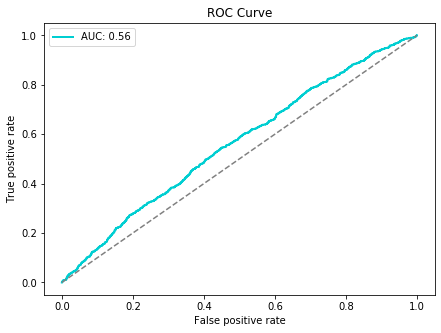

In [84]:
plot_ROC(y_val,results['predict_proba'],results['AUC'])

This model performs slightly better than a random guess.. Let's see what is the most importance feature

In [85]:
fitted_model.coef_

array([[ 0.00080608,  0.00991823, -0.00059365, -0.01683983,  0.29137688,
        -0.00956062,  0.03067579,  0.31652341, -0.10889516,  0.12248189,
        -0.06278421,  0.07074864, -0.03819385,  0.01261134,  0.02916623,
        -0.10889516, -0.01853184, -0.04028818,  0.003896  ,  0.01227683,
         0.10796285, -0.0631013 , -0.02103325,  0.03670926,  0.0663256 ,
         0.0584718 ,  0.03974682, -0.03819385,  0.10112685,  0.04255263,
         0.05909376,  0.04193453,  0.00182638,  0.00144609]])

In [87]:
feature_names = np.array(data_train_features_only_dummied.columns)

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['Department_Dresses' 'Class_Dresses' 'Class_Sweaters' 'Department_Tops'
 'Class_Blouses' 'Class_Trend' 'Department_Trend' 'Class_Skirts'
 'Class_Pants' 'Positive_fb_count']

Largest Coefs: 
['Department_Intimate' 'Division_Initmates' 'Department_Bottoms'
 'Class_Lounge' 'Class_Jeans' 'Department_Jackets' 'Class_Sleep'
 'Class_Shorts' 'Class_Jackets' 'Class_Legwear']


In [88]:
len(feature_names)

34

In [90]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [91]:
fitted_model,results = model_fit_train_score(model,X_train_add, y_train,X_val_add,y_val)

In [92]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.741 
F1 score: 0.847 
AUC score: 0.566


In [94]:
sorted_impt_index = fitted_model.feature_importances_.argsort()

In [99]:
print('Most important features: \n{}'.format(feature_names[sorted_impt_index[:-10:-1]]))

Most important features: 
['review_len' 'Age' 'clothing_ID' 'Positive_fb_count' 'Division_General'
 'Division_General Petite' 'Class_Knits' 'Class_Blouses' 'Class_Sweaters']


Let's try to add the features one by one to the review text

Starting with the most importance found in random forest model

In [115]:
# transform the documents in the training data to a document-term matrix
X_train_to_add = data_train_features_only_dummied.loc[list(X_train.index),'review_len'].to_numpy().reshape((13584,1))
X_train_vect_stack_1 = np.hstack((X_train_vectorized,X_train_to_add))

In [113]:
X_val_to_add = data_train_features_only_dummied.loc[list(X_val.index),"review_len"].to_numpy().reshape((4529,1))
X_val_vect_stack_1 = np.hstack((X_val_vectorized,X_val_to_add))

In [117]:
model = LogisticRegression()
fitted_model,results = model_fit_train_score(model,X_train_vect_stack_1, y_train,X_val_vect_stack_1,y_val)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [118]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.854 
F1 score: 0.909 
AUC score: 0.897


The model still performs worse than the text alone;

We will focus on using only the text for sentiment reviews

What about recommendation?

In [125]:
y2_train = data_train.loc[list(y_train.index),"Reco"]
y2_val = data_train.loc[list(y_val.index),"Reco"]

In [126]:
model = LogisticRegression()
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y2_train,X_val_vectorized,y2_val)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [127]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.887 
F1 score: 0.932 
AUC score: 0.915


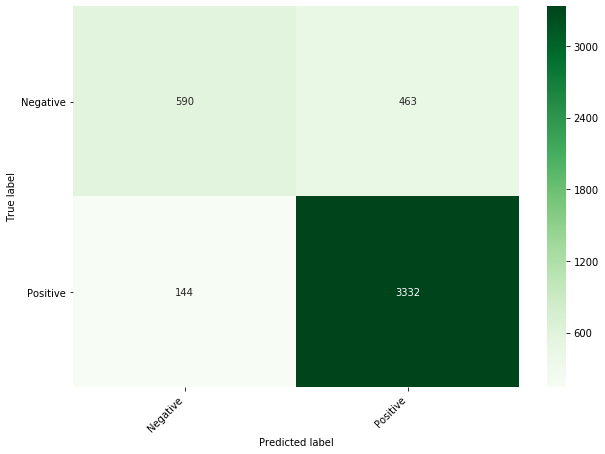

In [128]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

Recommendation is quite similar to the rating, let's focus our effort on maximizing performance for rating for now.. and we will check the reco once we have time

In [36]:
from sklearn.linear_model import LogisticRegressionCV


In [37]:
model = LogisticRegressionCV(Cs = [0.1,0.5,1,5,10],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')

In [38]:
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y_train,X_val_vectorized,y_val)

/Users/zhengzhiqing/opt/anaconda3/envs/metisnow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/zhengzhiqing/opt/anaconda3/envs/metisnow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

In [39]:
fitted_model

LogisticRegressionCV(Cs=[0.1, 0.5, 1, 5, 10], class_weight=None, cv=5,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=500, multi_class='ovr',
                     n_jobs=None, penalty='l2', random_state=123, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [40]:
fitted_model.C_

array([0.1])

In [41]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.877 
F1 score: 0.922 
AUC score: 0.922


In [42]:
#try to see the 
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['disappointed' 'unflattering' 'returning' 'cheap' 'bad' 'returned'
 'wanted' 'disappointing' 'completely' 'huge']

Largest Coefs: 
['compliments' 'perfect' 'comfortable' 'highly' 'glad' 'perfectly'
 'amazing' 'love' 'happy' 'comfy']


In [43]:
model = LogisticRegressionCV(Cs = [0.001,0.05,0.1],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y_train,X_val_vectorized,y_val)

In [44]:
fitted_model.C_

array([0.1])